In [2]:
# Load some modules
import numpy as np
import matplotlib.pyplot as plt
import copy

## Panelverfahren
Im Folgenden implementieren wir ein einfaches Panelverfahren, zuerst für die Simulation der stationären Umströmung eines dünnes Profils, dann für die Simulation der plötzlichen Anströmung eines Profils mit Bildung eines Anfahrwirbels.

### Stationäres Panelverfahren für dünne Profile
Mit dem zweidimensionalen Panelverfahren beschreiben wir ein dünnes Flügelprofil durch eine gegebene Anzahl $N$ von linearen Segmenten. Jedes Segment ist selbst als dünnes Profil beschrieben und wird potentialtheoretisch durch die Ergebnisse der Theorie der dünnen Profile für eine ebene Platte beschrieben. Das heißt, bei $1/4$ der Segmentlänge (der Angriffspunkt der Auftriebskraft für ein dünnes Profil) wird ein Potentialwirbel der Zirkulation $\Gamma$ plaziert. Es ergeben sich also $N$ unbekannte $\Gamma$-Werte, die bestimmt werden können, indem die Undurchlässigkeitsrandbedingung an $N$ diskreten Kontrollpunkten vorgegeben wird. Diese Kontrollpunkten sind bei $3/4$ der Segmentlänge (Siehe Folien für die Begründung dieser Wahl. Das ist auch ein Ergebnis der Theorie der dünnen Profile für ebene Platten). 

Zuerst definieren wir einige Input-Parameter, wie die Anzahl $N$ von Panelen, die Profilsehnenlänge $c$, die Anströmgeschwindigkeit $U$, die Profilmittellinie eines Profils der 4-Stelligen $\mathrm{NACA}$-Reihe und den Anstromwinkel $\alpha$

In [38]:
# Flow and discretisation parameters
alfa = 10 * np.pi / 180         # Angle of attack
N = 30                          # Number of panels to describe the airfoil
c = 1                           # Chord length
U = 1                           # Freestream velocity
NACA = [4,4,1,2]                # Four digits of the NACA profile to be considered

Jertzt können wir die Geometrie der Mittelline vom NACA-Profil definieren. 

In [39]:
# Define the geometry
def naca4(nums,x):
    m=nums[0]/100  
    p=nums[1]/10
    t=(nums[2]*10+nums[3])/100
    if x<=p:
        return c*m/(p**2)*(2*p*x-x**2)
    else:
        return c*m/((1-p)**2)*((1-2*p)+2*p*x-x**2)


Wenn die Mittellinie bekannt ist, können wir die Panele definieren, in dem wir einfach die Mittellinie in gerade Segmente teilen. Für jedes Segment können wir normale und tangente Einheitsvektoren definiren. Sie werden uns nützlich sein, um Geschwindigkeitskomponenten in die Richtung normal und parallel zum Profil zu bestimmen. Die Länge jedes Segments kann ebenfalls definiert werden. 

Es wird sich als praktisch erweisen, in diesem Fall das Profil um einen Winkel $\alpha$ um seine Nase zu drehen und horizontal anzuströmen, anstatt eine schräge Anströmung zu definieren. Das kann sehr einfach durch die Definition einer Rotationsmatrix erreicht werden, mit der wir alle Koordinate der Panele drehen können. 

Sind die Panele vollständig definiert, werden die Koordinaten der Potentialwirbel, des Kontrollpunkts und des Mittelpunkts von jedem Panel definiert. 

In [40]:
# Define the panels
# 
# I use a dictionary to define the properties of each panel.
# Using a class would be a more elegant solution, but we just 
# use a dictionary here for simplicity. The members of the dictionaries
# are panel properties, such as:
#
# segment  -> the coordinates of the two ends of each panel
# normal   -> the normal to each panel
# tangent  -> the tangent direction to each panel
# length   -> the length of the panel
# vortex   -> the coordinates of the vortex placed on the panel (1/4 of panel length)
# midpoint -> the coordinates of the midpoint of each panel (1/2 of panel length)
# control  -> the coordinates of the control point on each panel (3/4 of panel length)
#
panels = dict()
panels['segment'] = np.zeros((2,2,N))   # Indices are: (iEnd, iCoord, iPanel)
panels['normal'] = np.zeros((2,N))      # Indices are: (iCoord, iPanel)
panels['tangent'] = np.zeros((2,N))     # Indices are: (iCoord, iPanel)
panels['length'] = np.zeros((N))        # Indices are: (iPanel)

# The freestream flow is always horizontal. The profile is rotated to account
# for the angle of attach with a rotation matrix Rmat. Nmat is a further 90° 
# rotation matrix, utilised to find the normal vector. 
Rmat = np.asarray([[np.cos(-alfa), -np.sin(-alfa)], [np.sin(-alfa), np.cos(-alfa)]])
Nmat = np.asarray([[0, -1], [1, 0]])

# Loop over all panels and define their segments, tangents, lengths and normals
for iP in range(N):
    xA = iP*c/N;    xB = (iP+1)*c/N
    panels['segment'][0,:,iP] = Rmat@np.asarray([xA, naca4(NACA,xA)])
    panels['segment'][1,:,iP] = Rmat@np.asarray([xB, naca4(NACA,xB)])
    panels['tangent'][:,iP] = panels['segment'][1,:,iP] - panels['segment'][0,:,iP]
    panels['length'][iP] = np.linalg.norm(panels['tangent'][:,iP])
    panels['tangent'][:,iP] /= panels['length'][iP]
    panels['normal'][:,iP] = Nmat@panels['tangent'][:,iP]

# Once all segments are defined, also the position of the vortex-, 
# control- and midpoint can be defined 
panels['vortex'] = 3.0*panels['segment'][0]/4.0 + 1.0*panels['segment'][1]/4.0
panels['control'] = 1.0*panels['segment'][0]/4.0 + 3.0*panels['segment'][1]/4.0
panels['midpoint'] = 0.5*(panels['segment'][0] + panels['segment'][1])

Die Korrektheit der geometrischen Definition lässt sich mit einer graphischen Darstellung leicht überprüfen. 

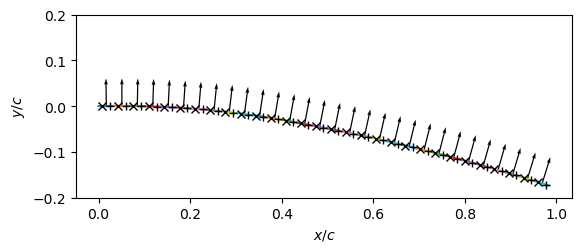

In [41]:
# Plot the panels, with their vortex- and controlpoints and the normals
plt.figure()
plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:])
plt.plot(panels['vortex'][0,:],panels['vortex'][1,:],'kx')
plt.plot(panels['control'][0,:],panels['control'][1,:],'k+')
plt.quiver(panels['midpoint'][0,:],panels['midpoint'][1,:], 
           panels['normal'][0,:], panels['normal'][1,:], width=0.0025)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel(r'$x/c$')
plt.ylabel(r'$y/c$')
plt.ylim([-0.2,0.2])
plt.show()

Wie vorher erwähnt, werden wir die von einem Potentialwirbel induzierte Geschwindigkeit in einem (Kontroll)Punkt oft im Panel-Verfahren berechnen müssen. Es lohnt sich also, diese Berechnung einer Funktion zu überlassen, welche hier unten implementiert wird. Die von einem Potentialwirbel induzierte Geschwindigkeit $\vec{w}$ hat den folgenden Ausdruck:
\begin{equation}
   \vec{w} = \frac{\Gamma}{2 \pi r} \hat{\theta} ,
\end{equation}
wobei ist $r$ der Betrag des Abstandsvektor $\vec{r}=\vec{x}_K - \vec{x}_W$ zwischen der Stelle des Kontrollpunkts $\vec{x}_K$ und des Wirbels $\vec{x}_W$, $\Gamma$ die Zirkulation des Wirbels und $\hat{\theta} = \hat{z} \times \vec{r}$ der lokale Einheitsvektor in Umfangsrichtung eines ziliyndrischen Koordinatensystems.  

In [42]:
# Define a function "vortexVelocity", which 
# computes the velocity induced at a point "ctrl",
# by a potential vortex placed at "vrtx" 
# with intensity "gamma"
def vortexVelocity(vrtx,ctrl,gamma,minr=0):
    r = ctrl-vrtx
    normr = np.linalg.norm(r)
    t = np.cross([0.0,0.0,1.0],[r[0],r[1],0.0])
    t /= np.linalg.norm(t)
    utheta = gamma/(2.0*np.pi*max([normr,minr]))
    return np.asarray([t[0]*utheta, t[1]*utheta])

Jetzt sind wir bereit, das Problem aufzustellen und zu lösen. Die $N$ unbekannte $\Gamma_i$-Werte der Zirkulation vom $i$-ten Panel werden durch die Forderung der Undurchlässigkeit an den $N$ Kontrollpunkten bestimmt. Diese Forderung für das allgemeine $j$-te Panel ist wie folgt mathematisch ausgedrückt:
\begin{equation}
\left( \vec{U}_\infty  + \sum_{i=1}^{N} \vec{w}_i(\vec{x}_{K_j}) \right) \cdot \hat{n}_j = 0 .
\end{equation}
Hier ist $\vec{w}_i(\vec{x}_{K_j})$ die vom $i$-ten Potentialwirbel induzierte Geschwindigkeit auf dem $j$-ten Kontrollpunkt. $\hat{n}_j$ ist die Normale zum $j$-ten Panel. Diese Gleichung stellt eine Zeile des Glecihungsystems dar. Wir stellen fest, dass der Term $\vec{U}_\infty \cdot \hat{n}_j$ bekannt ist und auf die rechte Seite gebracht werden kann, d.h.  
\begin{equation}
\sum_{i=1}^{N} \Gamma_i \vec{w}_{i,\Gamma=1}(\vec{x}_{K_j}) \cdot \hat{n}_j =  -\vec{U}_\infty \cdot  \hat{n}_j
\end{equation}
Hier wurde die Zirkulation $\Gamma_i$ des $i$-ten Wirbels explizit geschrieben, wobei jetzt $\vec{w}_{i,\Gamma=1}$ die vom $i$-ten Potentialwirbel mit Zirkulation $\Gamma_i=1$ induzierte Geschwindigkeit ist. Das ganze kann als Gleichungssystem 
\begin{equation}
\mathsf{A}\vec{\Gamma} = \vec{b} 
\end{equation}
umformt und gelöst werden. Benötigen Wir hierfür eine Kutta'sche Abflussbedingung?

In [43]:
# Define the influence matrix A and the right-hand-side b
A = np.zeros([N,N])
b = np.zeros([N])

# Compute A and b by looping over the the control points 
# (i.e. the equation, aka the rows of the matrix A)
# and the bound vortices (i.e. the columns of the matrix A)

# loop over control points
for iC,ctrl in enumerate(panels['control'].transpose()):
    # Apply the wall-normal component of the freestream to the r.h.s.
    b[iC] = -U*np.dot(np.asarray([1.0,0.0]), panels['normal'][:,iC])
    # loop over vortices
    for iV,vrtx in enumerate(panels['vortex'].transpose()):
        # Apply the velocity induced by every vortex on the control point
        A[iC,iV] = np.dot(vortexVelocity(vrtx,ctrl,1.0), panels['normal'][:,iC])
# solve the system A*Gamma = b and find the circulations
# of each bound potential vortex
Gamma = np.linalg.solve(A,b)
# compute the circulation density by dividing the
# circulation for each panel length
gamma = Gamma/panels['length']


Nachdem die Lösung erhalten wurde, können wir das Geschwindigkeitsfeld um das Profil darstellen. Um dies zu tun, schreiben wir zwei Hilfsfunktionen ```flowVelocity``` und ```computeFlowField```, welche  die von allen Wirbeln und der Anströmung induzierte Geschwindigkeit jeweils in einem beliebigen Punkt und in mehreren Punkten verteilt auf einem Chartesischen Gitter rechnen.

In [33]:
# Define a function that given a dictionary
# of "panels", their circulation "Gamma", the
# freestream velocity "U" and a point with coordinates
# "x" and "y" computes the velocity field
def flowVelocity(x,y,panels,Gamma,U):
    # initialise the velocity with the freestream velocity
    u = U*np.asarray([1.0,0.0])
    # loop over all vortices
    for iV,vrtx in enumerate(panels['vortex'].transpose()):
        # add the vortex velocity via superposition
        u += vortexVelocity(vrtx,[x,y],Gamma[iV])
    return u

# Write a function that utilises flowVelocity to compute
# the flow field on a set of points given by the cartesian grid
# defined via two arrays of coordinates "x" and "y"
def computeFlowField(x,y,panels,Gamma,U):
    u = np.zeros([2,x.size,y.size])
    for ix,xx in enumerate(x):
        for iy,yy in enumerate(y):
            u[:,ix,iy] = flowVelocity(x[ix],y[iy],panels,Gamma,U)   
    return u

Jetzt kann das Geschwindigkeitsfeld tatsächlich berechnet werden.

In [9]:
# Define two arrays of coordinates "x" and "y"
# at which compute and plot the velocity field
x = np.linspace(-0.1,1.1,100)
y = np.linspace(-0.3,0.1,100)

# Compute the velocity field utilising "computeFlowField"
u = computeFlowField(x,y,panels,Gamma,U)

Danach folgt die Darstellung beispielsweise durch Stromlinien mit ```matplotlib.pyplot.streamplot```.

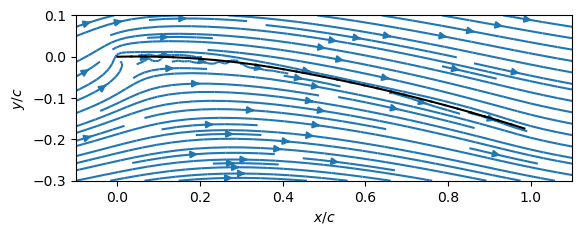

In [10]:
# Draw the panels and the velocity field by plotting
# streamlines with the function "streamplot" of "matplotlib.pyplot"
plt.figure()
plt.streamplot(x,y,u[0,:,:].transpose(),u[1,:,:].transpose())
plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:],'k')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.xlabel(r'$x/c$')
plt.ylabel(r'$y/c$')
plt.show()

Wir wollen die Differenz zwischen der Druck $p_t$ an der Oberseite und $p_b$ an der Unterseite des Profils quantifizieren. Das kann durch Bernoulli erreicht werden, z.B. 
\begin{equation}
 p_t - p_\infty =  \frac{1}{2} \rho \left(U_\infty^2 - \left| \vec{u}_t \right|^2 \right)
\end{equation}
\begin{equation}
 p_b - p_\infty =  \frac{1}{2} \rho \left(U_\infty^2 - \left| \vec{u}_b \right|^2 \right)
\end{equation}
wobei $\vec{u}_t$ und $\vec{u}_b$ die Geschwindigkeit an einem beliebigen Punkt der Ober- und Unterseite ist. Werden diese Gleichungen voneinander abgezogen und durch $ \frac{1}{2} \rho U_\infty^2$ dividiert, erhält man:
\begin{equation}
 \frac{p_t - p_b}{\frac{1}{2} \rho U_\infty^2} =  \Delta c_p = \frac{\left| \vec{u}_b  \right|^2 - \left| \vec{u}_t \right|^2}{U_\infty^2} 
\end{equation}
Gleichzeitig kann die Druckdifferenz zwischen Ober- und Unterseite des $j$-ten Panels (ein Panel ist selbst ein dunnes Profil!) durch die Auftriebskraft pro Längen- und Tiefeneinheit durch Kutta--Joukowski berechner werden, d.h.
\begin{equation}
 \frac{p_{j,t} - p_{j,b}}{\frac{1}{2} \rho U_\infty^2} = \Delta c_{p,j} = \frac{L_j^\prime / \ell_j}{\frac{1}{2} \rho U_\infty^2} = \frac{\rho U_\infty \Gamma_j / \ell_j}{\frac{1}{2} \rho U_\infty^2} =  \frac{\rho U_\infty \gamma_j}{\frac{1}{2} \rho U_\infty^2}
\end{equation}
wobei hier stellt $L_j^\prime$ den Auftrieb pro Tiefeneinheit, $\Gamma_j$ die Zirkulation des $j$-ten Panels und $\ell_j$ die Länge des Panels dar. Der Ausdruck mit den quadrierten Geschwindigkeiten kann verwendet werden, um dieselbe Druckdifferenz für Profile mit dünner aber endlicher Dicke zu ermitteln, wie sie z.B. durch XFOIL potentialtheoretisch zu simulieren sind. Im Folgenden vergleichen wir unser Ergebnis mit dem Ergebnis von XFOIL für ein ähnliches Profil mit endlicher Dicke mit dem Ziel, die Ergebnisse zu validieren. Stimmen die Ergebnisse überein?

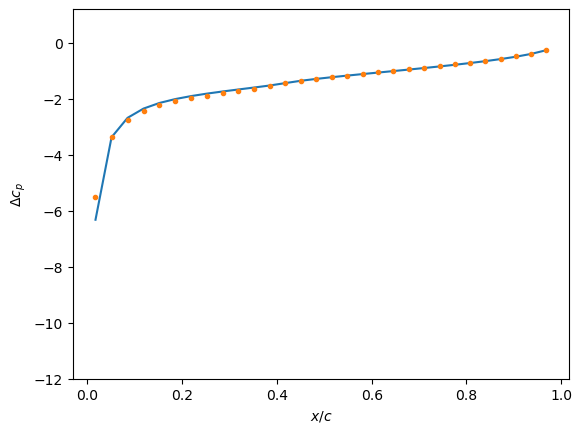

In [45]:
# Compute and plot the difference of cp between the 
# top and the bottom surface and compare it with 
# the results obtained with XFOIL for a profile of thin
# but finite thickness (e.g. NACA 4401)
plt.figure()

# Load the data from XFOIL
ul = np.loadtxt('ue_lower.txt')
ul = np.interp(panels['midpoint'][0,:], ul[:,1], ul[:,3])
uu = np.loadtxt('ue_upper.txt'); uu = uu[::-1,:]
uu = np.interp(panels['midpoint'][0,:], uu[:,1], uu[:,3])
# Compute the pressure coefficient difference from XFOIL data
u = (ul+uu); cp = ul**2-uu**2

# Plot \Delta cp from present data and compare it with XFOIL
plt.plot(panels['midpoint'][0,:],2*gamma)
plt.plot(panels['midpoint'][0,:],cp, '.')
plt.ylim([-12,1.2])
plt.xlabel(r'$x/c$')
plt.ylabel(r'$\Delta c_p$')
plt.show()

### Instationäres Panelverfahren
Im Folgenden möchten wir die plötzliche Anströmung eines Flügelprofils potentialtheoretisch beschreiben und die Entstehung eines Anfahrwirbels betrachten. 

Die instationäre Umströmung eines Flügelprofils wird durch folgende Gesetze beschrieben: 

* Das Kelvin'sche Zirkulationstheorem. In einer idealen (verlustfreien) Strömung eines barotropen Fluids unter einem konservativen Kraftfeld ist die Zirkulation entlang einer geschlossenen materiellen Linie konstant in der Zeit, d.h.
\begin{equation}
  \frac{\mathrm{d} \Gamma}{\mathrm{d} t} = 0 .
\end{equation}
Für ein urprünglich ruhendes Fluid bedeutet das, dass:
\begin{equation}
  \Gamma(t=0) = \Gamma(t) = 0
\end{equation}

* Die kinematische Randbedingung der Potentialtheorie, welche weiterhin gilt: Das dünne Flügelprofil ist eine Stromlinie. Diese Randbedingung wird im Rahmen des Panel-Verfahrens weiterhin nur an diskreten Punkten (die Kontrollpunkte) erfüllt sein. 

Im instationären Fall kann die Bildung eines Nachlaufs berücksichtigt werden. Die Zirkulation, welche  an der Hinterkante des Profils erzeugt wird, schwimmt in den Nachlauf mit der Geschwindkeit des Fluids. Der Nachlauf ist ein materieller Wirbelfaden und deswegen bewegt und verformt sich mit der Fluidgeschwindigkeit. Die Gesamtzirkulation im System, Summe der Zirkulation auf dem Profil  und im Nachlauf, muss dem Kelvin'schen Zirkulationstheorem entsprechen, d.h. 
\begin{equation}
  \sum_{i_P=0}^{N} \Gamma_{i_P} + \sum_{i_W=0}^{N_W} \Gamma_{i_W} = 0
\end{equation}
Es ergibt sich eine zeitliche Entwicklung der Gesamtzirkulation auf dem Profil. Am Anfang, bevor sich ein Nachlauf gebildet hat, ist diese null. Wir haben also die potentialtheoretische Lösung für $\Gamma_P = 0$, welche die Kutta'sche Abflussbedingung für eine stationäre Strömung noch nicht erfüllt. 

<img src="https://lorenabarba.com/wp-content/uploads/2013/12/startingvortex.gif" alt="drawing" width="200"/>

Die Gesamtzirkulation auf dem Profil kann sich nur ändern, wenn entgegengesetzte Zirkulation im Nachlauf abgelöst wird. Am Anfang wird also nicht nulle (negative, schauen Sie das Bild hier oben!) Zirkulationsdichte an der Hinterkante des Profils vorhanden sein, welche in den Nachlauf abgelöst wird. Der Nachlauf mit seiner Zirkulation induziert selbst eine Geschwindigkeit auf dem Profil und wird somit die Lösung auf dem Profil ändern. Die stärkste Zirkulationsänderungen ergeben sich am Anfang des instationären Vorgangs, so dass die stärkste Zirkulation im Nachlauf in den ersten Phasen sich ergeben werden. Die Potentialwirbel im Nachlauf schwimmen in der Zeit weiter weg vom Profil und induzieren darauf geringere Geschwindigkeiten, so stellt sich einen neuen stationären Zustand auf dem Profil. In diesem Zustand ist die Zirkulation an der Hinterkante des Profils null.

In jedem Zeitschritt erfolgen folgende Schritte:

* Wenn vorhanden, wird der Nachlauf sich mit dem Fluid mitbewegen.
* Ein neues Segment Nachlauf wird an der Hinterkante erzeugt. Der zugehörige Potentialwirbel hat die Zirkulation, die im vorigen Zeitschritt an der Hinterkante des Profils herrschte.
* Die Zirkulation am Profil wird aktualisiert, da der neue Nachlauf unterschiedliche Geschwindigkeiten am Flügelprofil induziert. 

Die Zirkulation am Profil wird genau so wie im stationären Fall aktualisiert. Nur induziert jetzt der Nachlauf auch Geschwindigkeiten in den Kontrollpunkten, das heißt:

\begin{equation}
\left( \vec{U}_\infty  + \sum_{i_P=1}^{N} \Gamma_{i_P} \vec{w}_{i_P}(\vec{x}_{K_j}) + \sum_{i_W=1}^{N_W} \Gamma_{i_W} \vec{w}_{i_W}(\vec{x}_{K_j}) \right) \cdot \hat{n}_j = 0 .
\end{equation}

Achten Sie darauf, dass nur die Zirkulationswerte am Profil tatsächliche Unbekannte sind, also:

\begin{equation}
\left( \sum_{i_P=1}^{N} \Gamma_{i_P} \vec{w}_{i_P}(\vec{x}_{K_j}) \right) \cdot \hat{n}_j = -\left( \vec{U}_\infty + \sum_{i_W=1}^{N_W} \Gamma_{i_W} \vec{w}_{i_W}(\vec{x}_{K_j})  \right) \cdot \hat{n}_j .
\end{equation}

Wir fangen mit der Definition der maximalen Anzahl an Nachlaufpanele an, das definiert wie viele Zeitschritte wir zeitlich fortschreiten werden. Die Gesamtzirkulation $\Gamma_{tot}$ im Zeitpunkt $t=0$ muss auch definiert werden. Wenn das Fluid in dem Zeitpunkt ruhte, ist diese null. Der Zeitschritt muss auch definiert werden, sowie zwei Vektoren von Koordinaten $\vec{x}$ und $\vec{y}$, welche wir für die Darstellung des Gechwindigkeitsprofils verwenden werden. 

In [18]:
# Input parameters for the simulation of the starting vortex
Nw = 200         #  Maximum number of panels in the wake
GammaTot=0       #  Total circulation in the system (circulation at time t=0)
dt = 0.005       #  Timestep
x = np.linspace(-0.1,2.2,200)   # x-grid (for visualising velocity field)
y = np.linspace(-0.3,0.1,100)   # y-grid (for visualising velocity field)

Danach können wir die Arrays definieren, die die Eigenschaften des Nachlaufs beinhalten.

In [19]:
# Define the wake vortices
# 
# At each timestep, a segment of wake is ejected into the flow.
# The segment will have the circulation of the trailing-edge panel
# on the profile. Since the wake panels are not supported by the 
# airfoil but are actual material lines, they will move (and deform)
# with the flow.
#
# Also here, I use a dictionary to define the properties of the wake.
# The members of the dictionaries are wake properties, such as:
#
# segment  -> the coordinates of the two ends of each wake panel
# vortex   -> the coordinates of the vortex placed on the panel (1/4 of panel length)
# strength -> the circulation of the wake vortex placed on each panel
#
wake = dict()
wake['segment'] = np.zeros((2,2,Nw))   # Indices are: (iEnd, iCoord, iPanel)
wake['strength'] = np.zeros((Nw))      # Indices are: (iPanel)
wake['vortex'] = np.zeros((2,Nw))      # Indices are: (iCoord, iPanel)


Im Folgenden werden wir häufig die vom Nachlauf induzierte Geschwindigkeit in einem beliebigen (Kontroll)Punkt bestimmen müssen. Dafür können wir die Funktion ```wakeVelocity``` einführen. Gleichzeitig können wir die Funktion ```computeFlowFieldWithWake``` definieren, welche das Geschwindigkeitsfeld auf einem Carthesischen Gitter für spätere Visualisierung. Zwei weitere Funktionen können eingeführt werden, um die Ergebnisse darzustellen. 

In [20]:
# Define a function "wakeVelocity", which
# computes the velocity induced by the wake 
# panels at a point (x,y). The function could also 
# take as imput the current length "iW" of the wake at
# a given time
def wakeVelocity(x,y,wake,iW,minr=0):
    # Define the velocity vector
    u = np.asarray([0.0, 0.0])
    # Loop over the wake panels
    for i in range(iW):
        # increment the velocity with the contribution
        # of the i-th wake vortex (linear superposition)
        u += vortexVelocity(wake['vortex'][:,-i-1],[x, y],wake['strength'][-i-1],minr)
    return u

# Define a convenience function "computeFlowFieldWithWake", 
# similar to "computeFlowField", which computes the flow field
# at a grid on coordinated defined by the vecotrs "x" and "y"
# considering also the influence of the wake
def computeFlowFieldWithWake(x,y,panels,wake,Gamma,U,iW):
    # define the velocity field
    u = np.zeros([2,x.size,y.size])
    # double loop over the grid
    for ix,xx in enumerate(x):
        for iy,yy in enumerate(y):
            # add flow and wake velocity
            u[:,ix,iy] = flowVelocity(x[ix],y[iy],panels,Gamma,U)   
            u[:,ix,iy] += wakeVelocity(x[ix],y[iy],wake,iW)
    return u

# Define a convenience function which plots the flow field
# at a time "iT" and saves the figure to a file
def saveFlowFigure(x,y,u,panels,iT):
    # Open figure
    fig = plt.figure()
    # Plot airfoil panels with "plot" and streamlines with "streamplot"
    plt.streamplot(x,y,u[0,:,:].transpose(),u[1,:,:].transpose())
    plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # Label the axes
    plt.xlabel(r'$x/c$')
    plt.ylabel(r'$y/c$')
    # Save the figure to file
    plt.savefig('flowField_'+str(iT)+'.png')
    # Close figure
    plt.close(fig)

# Define a convenience function which plots the position 
# of the wake vortices at a time "iT" and saves the figure to a file
def saveVortexFigure(x,y,panels,wake,iT,iW):
    # Open figure
    fig = plt.figure()
    # Plot airfoil panels
    plt.plot(panels['segment'][:,0,:],panels['segment'][:,1,:])
    # Plot wake vortices
    plt.plot(wake['vortex'][0,-iW-1:],wake['vortex'][1,-iW-1:],'.')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # Label the axes
    plt.xlabel(r'$x/c$')
    plt.ylabel(r'$y/c$')
    # Save figure to file
    plt.savefig('vortexField_'+str(iT)+'.png')
    # Close figure
    plt.close(fig)

Jetzt sind wir bereit für die Implementierung der Zeitschleife wie oben beschrieben! Die Kommentare begleiten Sie in dem Prozess. 

In [23]:
# Now we are ready for the unsteady solution 
# of the impulsive starting of an airfoil

t = 0        # Initialise time to zero

# We loop for a number of timestep iT = [0..Nw+1],
# in fact at the first timestep we have no wake vortices
# and only at the second we eject the first wake panel,
# so that we need Nw+1 timesteps to have Nw wake panels at
# the end.
for iT in range(Nw+1):
    
    # Print progress
    print('Computing time: '+str(t))
    
    # Number of wake panels at this timestep
    iW=iT-1
    
    # Compute the velocity 
    # --------------------
    # at each the extrema of each wake
    # panel segment. This needs to be done only when wake panels
    # are present, i.e. for iW>0
    if iW>0:
        # Define the array containing the wake panel velocity 
        u = np.zeros((2,2,iW))
        # Loop over all wake panels
        for i in range(iW):
            # Loop over each end of each panel
            for j in range(2):
                # Get the coordinate
                crd = wake['segment'][j,:,-i-1]
                # Compute the velocity by summing wake and airfoil contributions
                u[j,:,-i-1]  = flowVelocity(crd[0],crd[1],panels,Gamma,U)
                u[j,:,-i-1] += wakeVelocity(crd[0],crd[1],wake,iW)
    
    # Advect all panels
    # -----------------
    # Loop over all wake panels
    for i in range(iW):
        # Loop over each end of the panel
        for j in range(2):
            # Compute new position
            wake['segment'][j,:,-i-1] += u[j,:,-i-1]*dt
        # Adjust vortex position
        wake['vortex'][:,-i-1] = 0.25*( 3*wake['segment'][0,:,-i-1]
                                       +  wake['segment'][1,:,-i-1])
        
    # Eject a new wake panel
    # ----------------------
    # This occurs only if iW>=0, i.e. not for iT=0, 
    # since at that time we still have no flow.
    if iW>=0:
        # If this is the first time in which we eject
        # a wake panel, then one extrema of the wake panel
        # will be located at the airfoil trailing edge, and
        # the other at the point obtained by advecting the
        # trailing edge point with the flow velocity 
        if iW==0:
            # get the coordinate of the trailing edge
            crd = panels['segment'][1,:,-1]
            # comput the velocity here
            u  = flowVelocity(crd[0],crd[1],panels,Gamma,U)
            u += wakeVelocity(crd[0],crd[1],wake,iW)
            # advect the trailing edge point
            # and define the wake panel segment
            wake['segment'][1,:,-iW-1] = crd + u*dt
            wake['segment'][0,:,-iW-1] = crd
            
        # otherwise, the extrema of the wake panel are 
        # the trailing edge and the first point of the previous
        # wake panel.
        else:
            # define the wake panel segment
            wake['segment'][1,:,-iW-1] = wake['segment'][0,:,-iW]
            wake['segment'][0,:,-iW-1] = panels['segment'][1,:,-1]

        # update the wake vortex location for the new wake segment
        wake['vortex'][:,-iW-1] = 0.25*( 3*wake['segment'][0,:,-iW-1]
                                        +  wake['segment'][1,:,-iW-1])
        # update the wake strength for the new wake segment
        wake['strength'][-iW-1] = Gamma[-1]
    
    
    # Define the influence matrix A and the right-hand-side b
    A = np.zeros([N,N])
    b = np.zeros([N])

    # Compute A and b by looping over the the control points 
    # (i.e. the equation, aka the rows of the matrix A)
    # and the bound vortices (i.e. the columns of the matrix A)

    # loop over control points
    for iC,ctrl in enumerate(panels['control'].transpose()):
        # Apply the wall-normal component of the freestream to the r.h.s.
        b[iC] = -U*np.dot(np.asarray([1.0,0.0]), panels['normal'][:,iC])
        # Loop over the airfoil panels
        for iV,vrtx in enumerate(panels['vortex'].transpose()):
            # Apply the velocity induced by every vortex on the control point
            A[iC,iV] = np.dot(vortexVelocity(vrtx,ctrl,1.0), panels['normal'][:,iC])
        # Add the wake contribution to the r.h.s.
        b[iC]-= np.dot(wakeVelocity(ctrl[0],ctrl[1],wake,iW+1), panels['normal'][:,iC])
    # Correct the trailing edge equation for the Kelvin theorem dGamma/dt=0
    A[-1,:] = 1; b[-1]=GammaTot-np.sum(wake['strength'])
    # Solve for the new circulation distrubution on the airfoil
    Gamma = np.linalg.solve(A,b)
    
    # Increment time
    t += dt
    
    # Compute flow field
    u = computeFlowFieldWithWake(x,y,panels,wake,Gamma,U,iW)
    
    # Save figures
    saveFlowFigure(x,y,u,panels,iT)
    saveVortexFigure(x,y,panels,wake,iT,iW)
    

Computing time: 0
Computing time: 0.005
Computing time: 0.01
Computing time: 0.015
Computing time: 0.02
Computing time: 0.025
Computing time: 0.030000000000000002
Computing time: 0.035
Computing time: 0.04
Computing time: 0.045
Computing time: 0.049999999999999996
Computing time: 0.05499999999999999
Computing time: 0.05999999999999999
Computing time: 0.06499999999999999
Computing time: 0.06999999999999999
Computing time: 0.075
Computing time: 0.08
Computing time: 0.085
Computing time: 0.09000000000000001
Computing time: 0.09500000000000001
Computing time: 0.10000000000000002
Computing time: 0.10500000000000002
Computing time: 0.11000000000000003
Computing time: 0.11500000000000003
Computing time: 0.12000000000000004
Computing time: 0.12500000000000003
Computing time: 0.13000000000000003
Computing time: 0.13500000000000004
Computing time: 0.14000000000000004
Computing time: 0.14500000000000005
Computing time: 0.15000000000000005
Computing time: 0.15500000000000005
Computing time: 0.1600